In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Lambda, Layer, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_read_in_data import *
from fpr_tpr_calc import *

In [2]:
path1 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/signals/chaneut_cha200_neut50_chan2a.csv'
path2 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/signals/chaneut_cha250_neut150_chan2a.csv'
path3 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/signals/chaneut_cha300_neut100_chan2a.csv'
path4 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/signals/chaneut_cha400_neut200_chan2a.csv'
path5 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/signals/gluino_1000.0_neutralino_1.0_chan2a.csv'
path6 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/signals/pp23mt_50_chan2a.csv'
path7 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/signals/pp24mt_50_chan2a.csv'

In [3]:
paths = [path1, path2, path3, path4, path5, path6, path7]

In [4]:
#Getthe data
df_bkg = single_csv_to_df('/home/joe/Documents/Work/PhD/dark_machines/training_files/chan2a/background_chan2a_309.6.csv')

In [5]:
for path in paths:
    temp = single_csv_to_df(path)
    if (len(temp.columns) > len(df_bkg.columns)):
        diff = int(((len(temp.columns)-5)/5))-int(((len(df_bkg.columns)-5)/5))
        num = int(((len(df_bkg.columns) - 5)/5) + 1)
        for i in range(diff):
            df_bkg['obj'+str(num)]= -999
            df_bkg['E'+str(num)] = -999
            df_bkg['pt'+str(num)] = -999
            df_bkg['eta'+str(num)] = -999
            df_bkg['phi'+str(num)] = -999
            num+=1

In [6]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj17,E17,pt17,eta17,phi17,obj18,E18,pt18,eta18,phi18
0,84,zw,1,133393,1.54667,j,421874,90266.6,-2.2226,2.26849,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,132,zw,1,77548,0.834024,j,68290.9,60095.2,-0.472399,-0.88833,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,57,zw,1,77471.2,-2.47116,j,87589.5,69234.9,-0.692601,1.71304,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,14477,zw,1,252243,-0.919876,e-,207654,138183,0.964875,1.9307,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,37474797,z_jets,1,60407.4,2.13302,j,94951.7,89286.6,-0.292177,-0.571029,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20000,56911014,w_jets,1,110328,2.87069,j,78709.7,76357.2,0.106718,-1.01635,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
20001,159,zw,1,90218.9,0.0518147,j,105994,105397,0.0510878,-2.94213,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
20002,69488,zw,1,100668,-1.49739,b,85279.6,80213.6,0.313768,2.20261,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
20003,32489,zw,1,53212.4,0.47409,e+,111979,59021.1,-1.2555,-2.86251,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [7]:
#If the number of max objects is prime, another column needs to be added to mitigate 

In [8]:
if ((len(df_bkg.columns)-5) % 2 != 0):
    num = str(int(((len(df_bkg.columns) - 5)/5) + 1))
    df_bkg['obj'+num]= -999
    df_bkg['E'+num] = -999
    df_bkg['pt'+num] = -999
    df_bkg['eta'+num] = -999
    df_bkg['phi'+num] = -999

In [9]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj17,E17,pt17,eta17,phi17,obj18,E18,pt18,eta18,phi18
0,84,zw,1,133393,1.54667,j,421874,90266.6,-2.2226,2.26849,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,132,zw,1,77548,0.834024,j,68290.9,60095.2,-0.472399,-0.88833,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,57,zw,1,77471.2,-2.47116,j,87589.5,69234.9,-0.692601,1.71304,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,14477,zw,1,252243,-0.919876,e-,207654,138183,0.964875,1.9307,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,37474797,z_jets,1,60407.4,2.13302,j,94951.7,89286.6,-0.292177,-0.571029,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20000,56911014,w_jets,1,110328,2.87069,j,78709.7,76357.2,0.106718,-1.01635,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
20001,159,zw,1,90218.9,0.0518147,j,105994,105397,0.0510878,-2.94213,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
20002,69488,zw,1,100668,-1.49739,b,85279.6,80213.6,0.313768,2.20261,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
20003,32489,zw,1,53212.4,0.47409,e+,111979,59021.1,-1.2555,-2.86251,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [10]:
df = df_bkg.fillna(-999)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [11]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

In [12]:
E = [entry for entry in df.columns if entry[0] == 'E']
pt = [entry for entry in df.columns if entry[0:2] == 'pt']
eta = [entry for entry in df.columns if entry[0:2] == 'et']
phi = [entry for entry in df.columns if entry[0:2] == 'ph']

In [13]:
np_E = np.array(df[E])
np_pt = np.array(df[pt])
np_eta = np.array(df[eta])
np_phi = np.array(df[phi])

In [14]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [15]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

In [16]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (2, 2)
strides = (1, 1)
pool_size = (1, 1)

In [17]:
K.clear_session()

In [18]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon
    
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    #kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    #recon_loss = K.mean(recon_loss)
    return recon_loss
    
def my_vae_loss(y_true, y_pred):
    beta = 0.9
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = (1-beta)*recon + beta*kl
    return vae_loss

    
    #Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same', 
                name = 'conv_1')(x_input)
pool_1 = MaxPooling2D(pool_size = pool_size,
                          strides = 2, 
                          name = 'max_pool')(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same', 
                name = 'conv_2')(pool_1)
#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)#(pool_1)
cnn = Model(x_input, flatten, name = 'cnn')
cnn.summary()

shape = input_shape
    
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                            activation = act_fun,
                            name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                            activation = act_fun,
                            name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()
    
#Decoding
dense_shape = shape[0]*shape[1]*shape[2]
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(dense_shape, 
                            activation = act_fun, 
                            name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 20,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 4, 
                             kernel_size = kernel_size, 
                             #activation = 'sigmoid', 
                             padding = 'same', 
                             strides = strides, 
                             name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()
    
#Build the VAE model
#outputs = decoder(encoder(x_input)[2])
#vae = Model(x_input, outputs, name = 'vae')
    
#vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
#vae.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1, 18, 4)]        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 1, 18, 32)         544       
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 1, 9, 32)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 1, 9, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type

In [19]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class bVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(bVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            reconstruction_loss *= 14*4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            beta = 0.9
            total_loss = (1-beta)*reconstruction_loss + beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    #def call(self, inputs, **kwargs):
    #    return self.model(inputs, decoder)

In [20]:
#Build the VAE model
#outputs = decoder(encoder(x_input)[2])
bvae = bVAE(encoder, decoder)
bvae.compile(optimizer = 'rmsprop')#, loss = my_vae_loss, metrics = [kl_loss, recon_loss])

In [21]:
x_val = x_train[:int(len(x_train)/3.)]
x_train = x_train[int(len(x_train)/3.):]

In [22]:
epochs = 100
batch_size = 1000
history_val = bvae.fit(x = x_val, epochs = epochs, batch_size = batch_size, verbose = 0)

history_train = bvae.fit(x = x_train, epochs = epochs, batch_size = batch_size, verbose = 2)

Epoch 1/100
13/13 - 0s - loss: 2.5838 - reconstruction_loss: 23.0727 - kl_loss: 0.3073
Epoch 2/100
13/13 - 0s - loss: 1.0740 - reconstruction_loss: 9.9118 - kl_loss: 0.0920
Epoch 3/100
13/13 - 0s - loss: 1.6349 - reconstruction_loss: 15.1765 - kl_loss: 0.1303
Epoch 4/100
13/13 - 0s - loss: 1.8342 - reconstruction_loss: 16.6753 - kl_loss: 0.1852
Epoch 5/100
13/13 - 0s - loss: 1.3692 - reconstruction_loss: 12.7129 - kl_loss: 0.1088
Epoch 6/100
13/13 - 0s - loss: 1.4692 - reconstruction_loss: 13.9544 - kl_loss: 0.0819
Epoch 7/100
13/13 - 1s - loss: 1.0146 - reconstruction_loss: 9.2723 - kl_loss: 0.0971
Epoch 8/100
13/13 - 0s - loss: 1.5180 - reconstruction_loss: 13.6905 - kl_loss: 0.1655
Epoch 9/100
13/13 - 0s - loss: 2.6018 - reconstruction_loss: 25.2460 - kl_loss: 0.0857
Epoch 10/100
13/13 - 0s - loss: 2.5470 - reconstruction_loss: 23.4703 - kl_loss: 0.2222
Epoch 11/100
13/13 - 0s - loss: 2.6201 - reconstruction_loss: 24.9829 - kl_loss: 0.1353
Epoch 12/100
13/13 - 0s - loss: 1.5121 - re

Epoch 95/100
13/13 - 0s - loss: 2.0700 - reconstruction_loss: 19.5544 - kl_loss: 0.1273
Epoch 96/100
13/13 - 0s - loss: 0.9674 - reconstruction_loss: 8.7358 - kl_loss: 0.1042
Epoch 97/100
13/13 - 0s - loss: 1.3356 - reconstruction_loss: 11.8987 - kl_loss: 0.1619
Epoch 98/100
13/13 - 0s - loss: 0.7479 - reconstruction_loss: 6.2292 - kl_loss: 0.1389
Epoch 99/100
13/13 - 0s - loss: 1.6712 - reconstruction_loss: 14.8489 - kl_loss: 0.2070
Epoch 100/100
13/13 - 0s - loss: 1.1854 - reconstruction_loss: 9.6795 - kl_loss: 0.2416


In [23]:
_, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
y_pred = decoder.predict(z)

In [24]:
x_test_reshape = x_test.reshape(x_test.shape[0], -1)

In [25]:
x_test_df = pd.DataFrame(x_test_reshape, columns = variables)

In [26]:
x_test_E = np.array(x_test_df[E])
x_test_pt = np.array(x_test_df[pt])
x_test_phi = np.array(x_test_df[phi])
x_test_eta = np.array(x_test_df[eta])

In [27]:
y_pred_reshape = y_pred.reshape(y_pred.shape[0], -1)

In [28]:
y_pred_df = pd.DataFrame(y_pred_reshape, columns = variables)

In [29]:
y_pred_E = np.array(y_pred_df[E])
y_pred_pt = np.array(y_pred_df[pt])
y_pred_phi = np.array(y_pred_df[phi])
y_pred_eta = np.array(y_pred_df[eta])

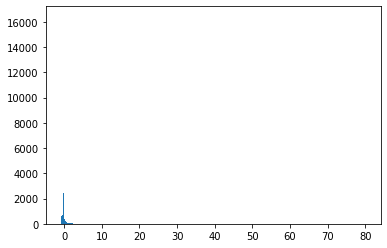

In [30]:
n, bins, patches = plt.hist(x_test_E.flatten(), 1000)

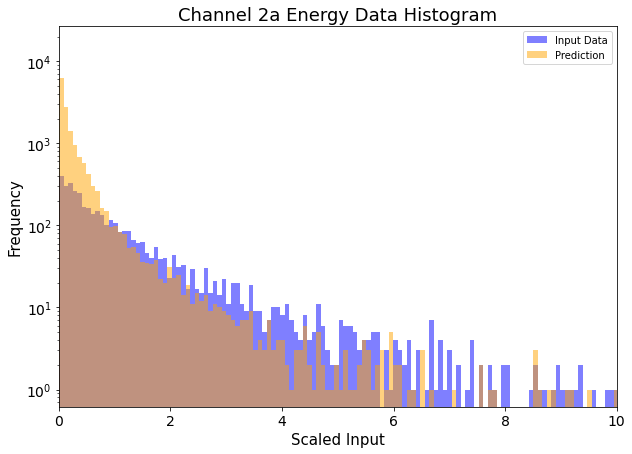

In [31]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Channel 2a Energy Data Histogram', fontsize = 18)
plt.hist(x_test_E.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_E.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

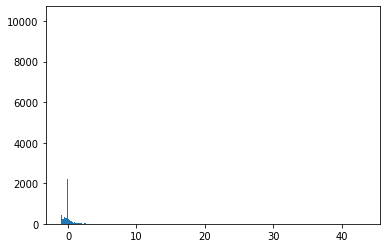

In [32]:
n, bins, patches = plt.hist(x_test_pt.flatten(), 1000)

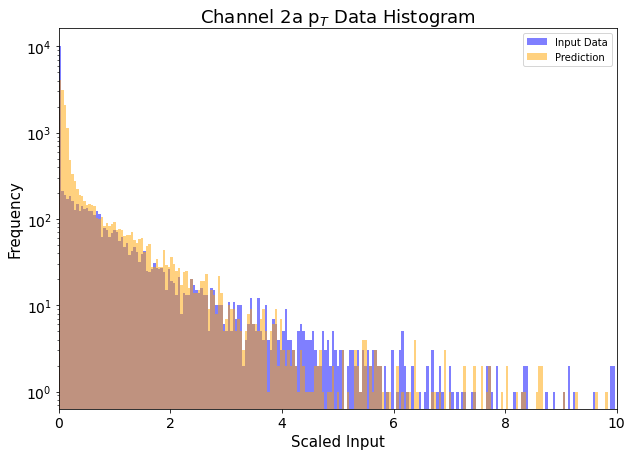

In [33]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 2a p$_T$ Data Histogram', fontsize = 18)
plt.hist(x_test_pt.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_pt.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

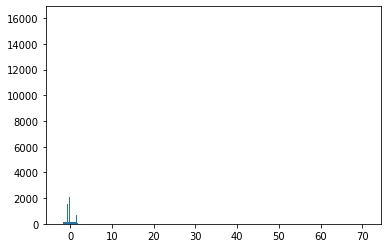

In [34]:
n, bins, patches = plt.hist(x_test_phi.flatten(), 1000)

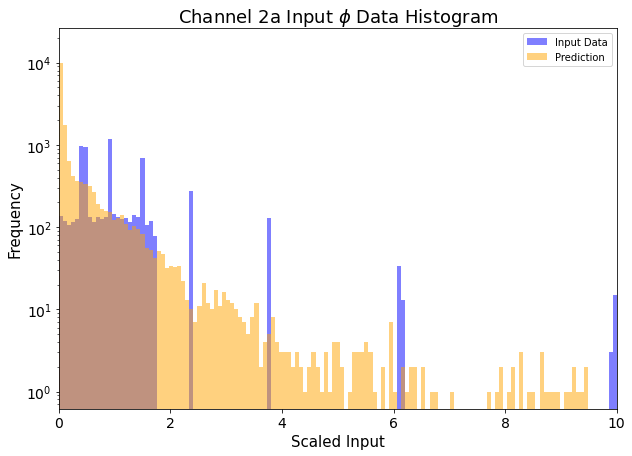

In [35]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 2a Input $\phi$ Data Histogram', fontsize = 18)
plt.hist(x_test_phi.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_phi.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

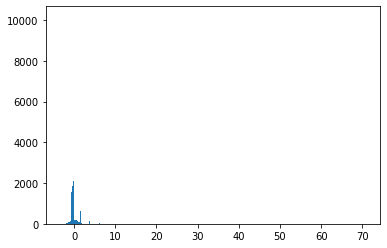

In [36]:
n, bins, patches = plt.hist(x_test_eta.flatten(), 1000)

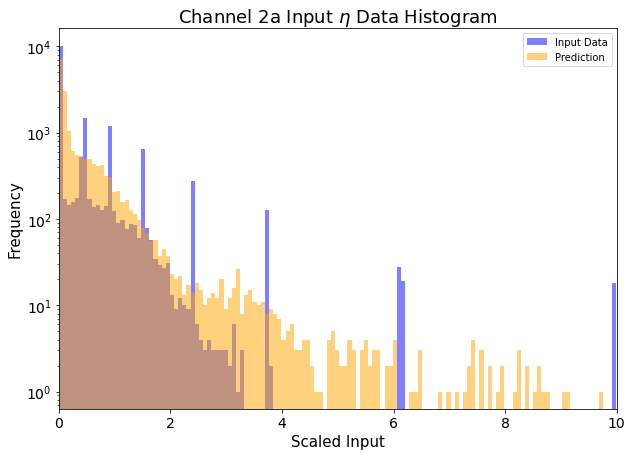

In [37]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 2a Input $\eta$ Data Histogram', fontsize = 18)
plt.hist(x_test_eta.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_eta.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

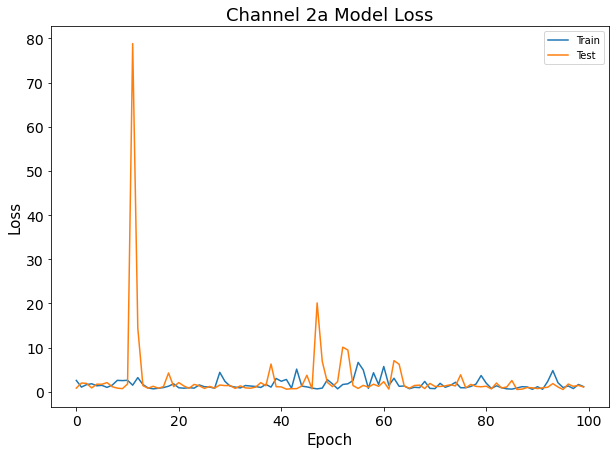

In [38]:
loss = [x for x in history_train.history['loss'] if x<100]
val_loss = [x for x in history_val.history['loss'] if x<100]
plt.figure(figsize = (10,7))
plt.plot(loss)
plt.plot(val_loss)
plt.title('Channel 2a Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc='upper left')
plt.show()

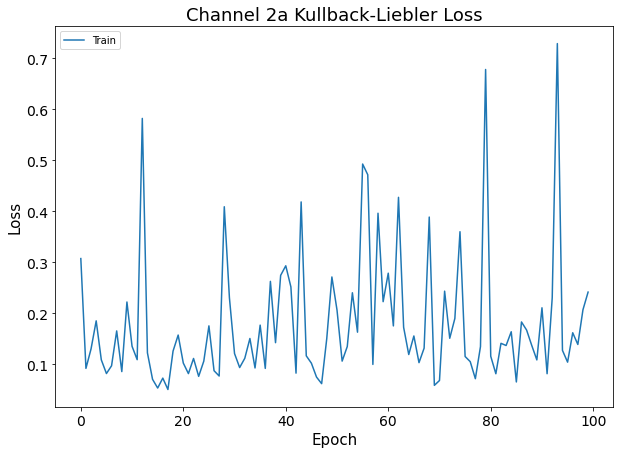

In [39]:
kl_loss = [x for x in history_train.history['kl_loss'] if x<10]
plt.figure(figsize = (10, 7))
plt.plot(kl_loss)
plt.title('Channel 2a Kullback-Liebler Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

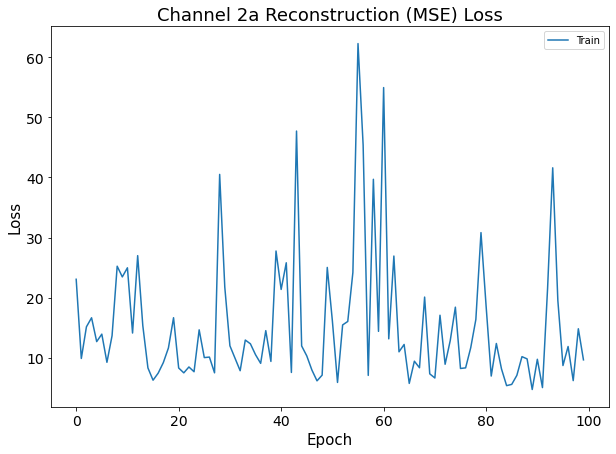

In [40]:
recon_loss = [x for x in history_train.history['reconstruction_loss'] if x<100]
plt.figure(figsize = (10, 7))
plt.plot(recon_loss)
plt.title('Channel 2a Reconstruction (MSE) Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

fpr1, tpr1 = fpr_tpr_calc(path1, vae, x_test, df_bkg)
fpr2, tpr2 = fpr_tpr_calc(path2, vae, x_test, df_bkg)
fpr3, tpr3 = fpr_tpr_calc(path3, vae, x_test, df_bkg)
fpr4, tpr4 = fpr_tpr_calc(path4, vae, x_test, df_bkg)
fpr5, tpr5 = fpr_tpr_calc(path5, vae, x_test, df_bkg)
fpr6, tpr6 = fpr_tpr_calc(path6, vae, x_test, df_bkg)
fpr7, tpr7 = fpr_tpr_calc(path7, vae, x_test, df_bkg)

In [41]:
fprs = []
tprs = []
for path in paths:
    df = single_csv_to_df(path)
    if (len(df)-5)%2 != 0:
        num = str(int(((len(df.columns) - 5)/5) + 1))
        df['obj'+num]= -999
        df['E'+num] = -999
        df['pt'+num] = -999
        df['eta'+num] = -999
        df['phi'+num] = -999

    if (len(df.columns)< len(df_bkg.columns)):
        diff = int(((len(df_bkg.columns)-5)/5))-int(((len(df.columns)-5)/5))
        num = int(((len(df.columns) - 5)/5) + 1)
        for i in range(diff):
            df['obj'+str(num)]= -999
            df['E'+str(num)] = -999
            df['pt'+str(num)] = -999
            df['eta'+str(num)] = -999
            df['phi'+str(num)] = -999
            num+=1
    df = df.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)


    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    _, x_test_bsm, _, y_test_bsm = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

    #x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
    x_test_bsm = x_test_bsm.reshape((x_test_bsm.shape[0], 1, -1, 4))
    _, _, z_bsm = encoder.predict(x_test_bsm.reshape(x_test_bsm.shape[0], 1, -1, 4))
    y_bsm = decoder.predict(z_bsm)
    _, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
    y_sm = decoder.predict(z)
    y_total = np.append(y_sm, y_bsm)
    y_sm = y_sm.flatten()
    y_bsm = y_bsm.flatten()
    
    
    y_true = np.append(np.zeros(len(y_sm)), np.ones(len(y_bsm)))
    y_total_norm = y_total/np.linalg.norm(y_total)
    
    fpr, tpr, _ = roc_curve(y_true, y_total_norm)
    fprs.append(fpr)
    tprs.append(tpr)

In [42]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
#fprs = [fpr1, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7]
#tprs = [tpr1, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7]
signals = ['chaneut_cha200_neut50', 
           'chaneut_cha250_neut150', 
           'chaneut_cha300_neut100', 
           'chaneut_cha400_neut200', 
           'gluino_1000.0_neutralino_1.0', 
           'pp23mt_50', 
           'pp24mt_50']

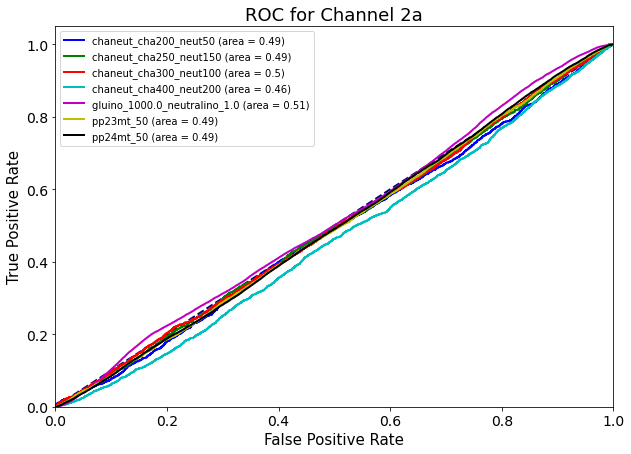

In [43]:
lw = 2
plt.figure(figsize = (10, 7))
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0, 1.05])
plt.title('ROC for Channel 2a', fontsize = 18)
for fpr, tpr, sig, col in zip(fprs, tprs, signals, colours):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = col, lw = lw, 
             label = '{} (area = {})'.format(sig, round(roc_auc, 2)))
plt.legend()
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [44]:
from performance import *

In [45]:
y_pred = y_pred.flatten()

In [46]:
AUC = []
epsilon1 = []
epsilon2 = []
epsilon3 = []

In [47]:
for i in paths:
    df_sig = single_csv_to_df(path1)
    if ((len(df_sig.columns)-5) % 2 != 0):
        num = str(int(((len(df_sig.columns) - 5)/5) + 1))
        df_sig['obj'+num]= -999
        df_sig['E'+num] = -999
        df_sig['pt'+num] = -999
        df_sig['eta'+num] = -999
        df_sig['phi'+num] = -999
        
    if (len(df_sig.columns)< len(df_bkg.columns)):
        diff = int(((len(df_bkg.columns)-5)/5))-int(((len(df_sig.columns)-5)/5))
        num = int(((len(df_sig.columns) - 5)/5) + 1)
        for i in range(diff):
            df_sig['obj'+str(num)]= -999
            df_sig['E'+str(num)] = -999
            df_sig['pt'+str(num)] = -999
            df_sig['eta'+str(num)] = -999
            df_sig['phi'+str(num)] = -999
            num+=1
    
    df = df_sig.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    #Now we one_hot encode the data to make sure we have a class definition
    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)

    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                        df[processes].values, 
                                                        shuffle = True,
                                                        random_state = 42,
                                                        test_size = 0.1)
    x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

    y_pred_sig = vae.predict(x_test)
    y_pred_sig = y_pred_sig.flatten()

    auc, ep1, ep2, ep3 = performance(y_pred, y_pred_sig)

    AUC.append(auc)
    epsilon1.append(ep1)
    epsilon2.append(ep2)
    epsilon3.append(ep3)

NameError: name 'vae' is not defined

In [ ]:
AUC

In [ ]:
epsilon1

In [ ]:
epsilon2

In [ ]:
epsilon3